# 1. DR-VAE

## 1.0. Basic Constrained Anomalies

In [ ]:
from functools import partial
from typing import Sequence

import flax
import flax.linen as nn
from flax.training import train_state
import jax
from jax import grad
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
import pandas as pd

def f1(x):
    return x[0]

def f2(x):
    return x[0] + x[1]

def generate_anomalies(f1, f2, x0, n_iter=1000, tol=1.0, lr=1e-2):
    x_morphed = x0.copy()
    for _ in range(n_iter):
        x_delta = grad(f2)(x_morphed)
        grad1 = grad(f1)(x_morphed)
        # orthogonalize with respect to f1
        x_delta = x_delta - (x_delta @ grad1) * grad1/jnp.linalg.norm(grad1)**2
        x_morphed = x_morphed + lr * x_delta

        if jnp.abs(f2(x_morphed) - f2(x0)) > tol:
            break
    if jnp.abs(f2(x_morphed) - f2(x0)) > tol:
        print(f"x_original: {x0}")
        print(f"x_morphed : {x_morphed}\n")
        print(f"f1(x_original): {f1(x0)}")
        print(f"f2(x_original): {f2(x0)}\n")
        print(f"f1(x_morphed) : {f1(x_morphed)}")
        print(f"f2(x_morphed) : {f2(x_morphed)}")

        return x0, x_morphed

    return None, None

In [ ]:
x0 = jr.normal(jr.PRNGKey(0), shape=(5,))

x0, x_morphed = generate_anomalies(f1, f2, x0)

x_original: [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]
x_morphed : [ 0.18784384 -0.27334356 -0.2710917   1.2490593   0.24447003]

f1(x_original): 0.18784384429454803
f2(x_original): -1.09549880027771

f1(x_morphed) : 0.18784384429454803
f2(x_morphed) : -0.08549971878528595


## 1.1. DR-VAE

In [ ]:
# Encoder that returns Gaussian moments
class Encoder(nn.Module):
    features: Sequence[int]
    activation: nn.Module = nn.relu

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        y1 = nn.Dense(self.features[-1])(x)
        y2 = nn.Dense(self.features[-1])(x)
        y2 = nn.softplus(y2)

        return y1, y2

# Decoder
class Decoder(nn.Module):
    features: Sequence[int]
    activation: nn.Module = nn.relu

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)

        return x

In [ ]:
def gaussian_kl(mu, sigmasq):
    """KL divergence from a diagonal Gaussian to the standard Gaussian."""
    return -0.5 * jnp.sum(1. + jnp.log(sigmasq) - mu**2. - sigmasq)

def gaussian_sample(key, mu, sigmasq):
    """Sample a diagonal Gaussian."""
    noise1 = jr.normal(key, shape=(1,))
    noise2 = jr.normal(key, shape=mu.shape)
    return mu + jnp.sqrt(sigmasq) * jr.normal(key, mu.shape)

def gaussian_logpdf(x_pred, x):
    """Gaussian log pdf of data x given x_pred."""
    return -0.5 * jnp.sum((x - x_pred)**2., axis=-1)

def elbo(key, params, split_idx, input, encoder_apply, decoder_apply):
    """Monte Carlo estimate of the negative evidence lower bound."""
    enc_params, dec_params = params[:split_idx], params[split_idx:]
    mu, sigmasq = encoder_apply(enc_params, input)
    z_pred = gaussian_sample(key, mu, sigmasq)
    x_pred = decoder_apply(dec_params, z_pred)

    return gaussian_logpdf(x_pred, input) - gaussian_kl(mu, sigmasq), x_pred

def dr_reg(input, x_pred, pred_fn, tol=1e-6):
    x_disc = pred_fn(input)
    x_pred_disc = pred_fn(x_pred)
    dr_reg_val = (x_disc - x_pred_disc) ** 2

    return dr_reg_val

def binary_loss(key, params, split_idx, input, encoder_apply, decoder_apply,
                pred_fn1, pred_fn2, beta1, beta2, tol=1e-6):
    """Binary cross-entropy loss."""
    elbo_val, x_pred = elbo(key, params, split_idx, input, encoder_apply, decoder_apply)
    dr_reg1 = dr_reg(input, x_pred, pred_fn1, tol)
    dr_reg2 = dr_reg(input, x_pred, pred_fn2, tol)
    result = -elbo_val + beta1 * dr_reg1 + beta2 * dr_reg2

    return result

In [ ]:
@partial(jax.jit, static_argnums=(3, 4, 5, 6, 7))
def train_step(i, state, batch, encoder_apply, decoder_apply, split_idx,
               pred_fn1, pred_fn2, beta1, beta2):
    key = jr.PRNGKey(i)
    binary_loss_fn = lambda params, key, input: binary_loss(
        key, params, split_idx, input, encoder_apply, decoder_apply,
        pred_fn1, pred_fn2, beta1, beta2
    )
    keys = jr.split(key, len(batch))
    loss_fn = lambda params: jnp.mean(
        jax.vmap(binary_loss_fn, (None, 0, 0))(params, keys, batch)
    )
    loss, grads = jax.value_and_grad(loss_fn)(state.params)  # Get loss and gradients for loss
    state = state.apply_gradients(grads=grads)  # Optimizer update step

    return state, loss

def train_dr_vae(pred_fn1, pred_fn2, X_train, beta1, beta2, z_dim,
                 key=0, n_epochs=100, batch_size=128, lr=1e-2, verbose=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    *_, x_dim = X_train.shape
    n = len(X_train)

    encoder_feats = [50, z_dim]
    decoder_feats = [50, x_dim]

    key_enc, key_dec = jr.split(key)

    # Encoder
    encoder = Encoder(encoder_feats)
    params_enc = encoder.init(key_enc, jnp.ones(x_dim,))['params']
    params_enc, unflatten_fn_enc = ravel_pytree(params_enc)
    apply_fn_enc = lambda params, x: encoder.apply(
        {'params': unflatten_fn_enc(params)}, x
    )

    # Decoder
    decoder = Decoder(decoder_feats)
    params_dec = decoder.init(key_dec, jnp.ones(z_dim,))['params']
    params_dec, unflatten_fn_dec = ravel_pytree(params_dec)
    apply_fn_dec = lambda params, x: decoder.apply(
        {'params': unflatten_fn_dec(params)}, x
    )
    params = jnp.array([*params_enc, *params_dec])
    split_idx = len(params_enc)

    # Train state
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=100,
        decay_steps=n//batch_size * n_epochs,
        end_value=1e-5
    )
    optimizer = optax.adam(lr_schedule)
    state = train_state.TrainState.create(
        apply_fn=None, params=params, tx=optimizer
    )

    for epoch in jnp.arange(1, n_epochs+1):
        key = jr.PRNGKey(epoch)
        idx = jr.permutation(key, n)
        X_train = X_train[idx]
        n_batch = n // batch_size
        if n % batch_size != 0:
            n_batch += 1
        losses = []

        for idx in range(n_batch):
            lb, ub = idx * batch_size, (idx+1) * batch_size
            X_batch = X_train[lb:ub]
            state, loss = train_step(
                idx, state, X_batch, apply_fn_enc, apply_fn_dec,
                split_idx, pred_fn1, pred_fn2, beta1, beta2
            )
            losses.append(loss)
        if verbose:
            print(f"Epoch {epoch} average loss: {jnp.mean(jnp.array(losses))}")

    params_enc, params_dec = state.params[:split_idx], state.params[split_idx:]
    result = {
        "params_enc": params_enc,
        "apply_fn_enc": apply_fn_enc,
        "params_dec": params_dec,
        "apply_fn_dec": apply_fn_dec,
    }

    return result


In [ ]:
# Generate synthetic dataset
x_dim = 50
n_train, n_test = 10_000, 10_000

xgrid = jnp.linspace(-2, 2, x_dim)[:,None]
X_mean, X_var = jnp.zeros(x_dim), jnp.linspace(0.1, 1.0, x_dim)

def K_squared_exp(x1, x2, sig2, Sinv):
     """ K(x1,x2) = sig2*exp(-1/2 (x1-x2) Sinv (x1-x2)) """
     dist = x1[:,None] - x2[None,:]
     qterm = jnp.sum(jnp.matmul(dist, Sinv)*dist, axis=-1)

     return sig2*jnp.exp(-.5*qterm)

Sigma = K_squared_exp(xgrid, xgrid, 1, 15*jnp.eye(1)) + jnp.eye(len(xgrid))*1e-4

# scale variances so the first dimension is small, last is big
sig = jnp.sqrt(X_var)
scale = jnp.dot(sig[:,None], sig[None,:])
Sigma *= scale

keys = jr.split(jr.PRNGKey(0), 2)
Sigma_c = jnp.linalg.cholesky(Sigma)
X_train = jnp.dot(jr.normal(keys[0], (n_train, x_dim)), Sigma_c.T)
X_test = jnp.dot(jr.normal(keys[1], (n_test, x_dim)), Sigma_c.T)

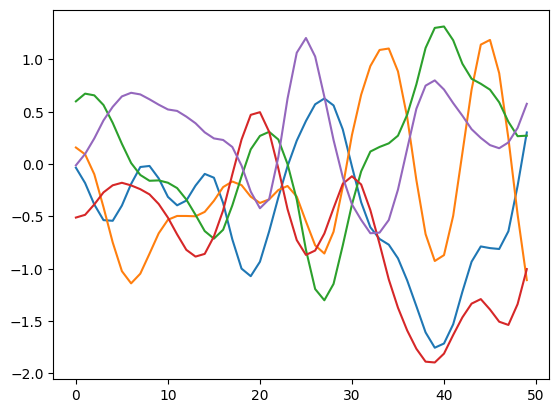

In [ ]:
# Plot 5 examples
fig, ax = plt.subplots()
for i in range(5):
    x = X_train[i]
    ax.plot(jnp.arange(x_dim), x)
plt.show()

In [ ]:
def compute_errors(f, X_test, result, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def compute_error(key, x):
        mu, sigmasq = result["apply_fn_enc"](
            result["params_enc"], x
        )
        z_pred = gaussian_sample(key, mu, sigmasq)
        x_pred = result["apply_fn_dec"](
            result["params_dec"], z_pred
        )
        gen_err = (x - x_pred) ** 2
        disc_err = (f(x) - f(x_pred)) ** 2

        return gen_err, disc_err

    keys = jr.split(key, len(X_test))
    gen_errs, disc_errs = jax.vmap(compute_error)(keys, X_test)
    gen_errs, disc_errs = jnp.sqrt(jnp.mean(gen_errs)), jnp.sqrt(jnp.mean(disc_errs))

    return gen_errs, disc_errs

In [ ]:
betas = [0.0, 1.56, 3.12, 6.25, 12.50, 25.00, 50.00, 100]
gen_errs, disc_errs = [], []

for beta in betas:
    print(f"beta: {beta}")
    result = train_dr_vae(f1, f2, X_train, beta, 0.0, 10, key=0, n_epochs=100, batch_size=256, lr=1e-2)
    gen_err, disc_err = compute_errors(f1, X_test, result)
    gen_errs.append(gen_err)
    disc_errs.append(disc_err)
    print(f"\n")

beta: 0.0
Epoch 1 average loss: 20.213239669799805
Epoch 2 average loss: 12.94678020477295
Epoch 3 average loss: 10.836878776550293
Epoch 4 average loss: 10.238920211791992
Epoch 5 average loss: 9.919827461242676
Epoch 6 average loss: 9.742220878601074
Epoch 7 average loss: 9.705231666564941
Epoch 8 average loss: 9.639877319335938
Epoch 9 average loss: 9.588236808776855
Epoch 10 average loss: 9.589489936828613
Epoch 11 average loss: 9.603111267089844
Epoch 12 average loss: 9.553205490112305
Epoch 13 average loss: 9.509322166442871
Epoch 14 average loss: 9.526114463806152
Epoch 15 average loss: 9.5000581741333
Epoch 16 average loss: 9.519068717956543
Epoch 17 average loss: 9.518457412719727
Epoch 18 average loss: 9.496474266052246
Epoch 19 average loss: 9.507521629333496
Epoch 20 average loss: 9.499785423278809
Epoch 21 average loss: 9.52343463897705
Epoch 22 average loss: 9.477968215942383
Epoch 23 average loss: 9.494170188903809
Epoch 24 average loss: 9.47278881072998
Epoch 25 average

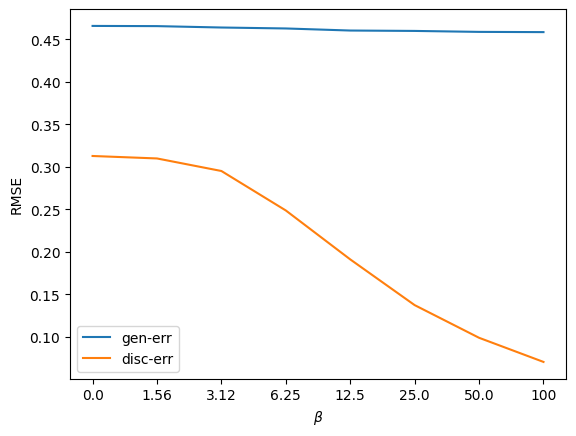

In [ ]:
fig, ax = plt.subplots()
ax.plot(jnp.arange(len(gen_errs)), gen_errs, label="gen-err");
ax.plot(jnp.arange(len(disc_errs)), disc_errs, label="disc-err");
ax.set_xlabel(r"$\beta$")
ax.set_xticks(jnp.arange(len(gen_errs)), [str(beta) for beta in betas]);
ax.set_ylabel("RMSE")
ax.legend();

In [ ]:
def get_latent_var(x, result, key):
    mu, sigmasq = result["apply_fn_enc"](
        result["params_enc"], x
    )
    z_pred = gaussian_sample(key, mu, sigmasq)

    return z_pred

def generate_subspace_anomalies(f1, f2, z0, result, n_iter=2000, tol=0.2,
                                lr=5.0, key=0, verbose=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)

    decode_fn = lambda z: result["apply_fn_dec"](result["params_dec"], z)
    x0 = decode_fn(z0)
    x_morphed = x0.copy()
    z_morphed = z0.copy()

    for _ in range(n_iter):
        key, subkey = jr.split(key)
        f1_induced = lambda z: f1(decode_fn(z))
        f2_induced = lambda z: f2(decode_fn(z))

        z_delta = grad(f2_induced)(z_morphed)
        grad1 = grad(f1_induced)(z_morphed)
        # orthogonalize with respect to f1
        z_delta = z_delta - (z_delta @ grad1) * grad1/jnp.linalg.norm(grad1)**2
        z_morphed = z_morphed + lr * z_delta
        x_morphed = decode_fn(z_morphed)

        if jnp.abs(f2(x_morphed) - f2(x0)) > tol:
            break

    if jnp.abs(f2(x_morphed) - f2(x0)) > tol:
        if verbose:
            print(f"x_original: {x0}")
            print(f"x_morphed : {x_morphed}\n")
            print(f"f1(x_original): {f1(x0)}")
            print(f"f2(x_original): {f2(x0)}\n")
            print(f"f1(x_morphed) : {f1(x_morphed)}")
            print(f"f2(x_morphed) : {f2(x_morphed)}")
        return x0, x_morphed

    return None, None

In [ ]:
betas = [0.0, 1.56, 3.12, 6.25, 12.50, 25.00, 50.00, 100]
errors = {}
z0 = jr.normal(jr.PRNGKey(0), shape=(10,))

for beta1 in betas:
    for beta2 in betas:
        print(f"beta1: {beta1}, beta2: {beta2}")
        result = train_dr_vae(f1, f2, X_train, beta1, beta2, 10, key=0, n_epochs=100,
                              batch_size=256, lr=1e-2, verbose=False)
        x0, x_morphed = generate_subspace_anomalies(f1, f2, z0, result, verbose=False)
        if beta1 not in errors:
            errors[beta1] = {}
        if x0 is not None and x_morphed is not None:
            errors[beta1][beta2] = abs(x0[0] - x_morphed[0])
        else:
            errors[beta1][beta2] = 0.0

beta1: 0.0, beta2: 0.0
beta1: 0.0, beta2: 1.56
beta1: 0.0, beta2: 3.12
beta1: 0.0, beta2: 6.25
beta1: 0.0, beta2: 12.5
beta1: 0.0, beta2: 25.0
beta1: 0.0, beta2: 50.0
beta1: 0.0, beta2: 100
beta1: 1.56, beta2: 0.0
beta1: 1.56, beta2: 1.56
beta1: 1.56, beta2: 3.12
beta1: 1.56, beta2: 6.25
beta1: 1.56, beta2: 12.5
beta1: 1.56, beta2: 25.0
beta1: 1.56, beta2: 50.0
beta1: 1.56, beta2: 100
beta1: 3.12, beta2: 0.0
beta1: 3.12, beta2: 1.56
beta1: 3.12, beta2: 3.12
beta1: 3.12, beta2: 6.25
beta1: 3.12, beta2: 12.5
beta1: 3.12, beta2: 25.0
beta1: 3.12, beta2: 50.0
beta1: 3.12, beta2: 100
beta1: 6.25, beta2: 0.0
beta1: 6.25, beta2: 1.56
beta1: 6.25, beta2: 3.12
beta1: 6.25, beta2: 6.25
beta1: 6.25, beta2: 12.5
beta1: 6.25, beta2: 25.0
beta1: 6.25, beta2: 50.0
beta1: 6.25, beta2: 100
beta1: 12.5, beta2: 0.0
beta1: 12.5, beta2: 1.56
beta1: 12.5, beta2: 3.12
beta1: 12.5, beta2: 6.25
beta1: 12.5, beta2: 12.5
beta1: 12.5, beta2: 25.0
beta1: 12.5, beta2: 50.0
beta1: 12.5, beta2: 100
beta1: 25.0, beta2

In [ ]:
errors

{0.0: {0.0: Array(0.05255575, dtype=float32),
  1.56: Array(0.40604612, dtype=float32),
  3.12: Array(0.06458747, dtype=float32),
  6.25: Array(0.03600234, dtype=float32),
  12.5: Array(0.08837646, dtype=float32),
  25.0: Array(0.09338455, dtype=float32),
  50.0: Array(0.09641765, dtype=float32),
  100: Array(0.11725257, dtype=float32)},
 1.56: {0.0: Array(0.06911994, dtype=float32),
  1.56: Array(0.07070026, dtype=float32),
  3.12: Array(0.03687883, dtype=float32),
  6.25: Array(0.06749618, dtype=float32),
  12.5: Array(0.07843345, dtype=float32),
  25.0: Array(0.07961115, dtype=float32),
  50.0: Array(0.05372885, dtype=float32),
  100: Array(0.09749511, dtype=float32)},
 3.12: {0.0: Array(0.04073016, dtype=float32),
  1.56: Array(0.01915374, dtype=float32),
  3.12: Array(0.03434518, dtype=float32),
  6.25: Array(0.00604734, dtype=float32),
  12.5: Array(0.06218319, dtype=float32),
  25.0: Array(0.06785049, dtype=float32),
  50.0: Array(0.06412417, dtype=float32),
  100: Array(0.08138

In [ ]:
df = pd.DataFrame(errors).T.astype(float)

In [ ]:
df

,0.00,1.56,3.12,6.25,12.50,25.00,50.00,100.00
0.00,0.052556,0.406046,0.064587,0.036002,0.088376,0.093385,0.096418,0.117253
1.56,0.069120,0.070700,0.036879,0.067496,0.078433,0.079611,0.053729,0.097495
3.12,0.040730,0.019154,0.034345,0.006047,0.062183,0.067850,0.064124,0.081386
6.25,0.034087,0.013736,0.836781,0.000000,0.000967,0.098275,0.062449,0.076695
12.50,0.281967,0.124505,0.148219,0.012297,0.061305,0.020720,0.064589,0.088600
25.00,0.057995,0.083212,0.053403,0.015103,0.077278,0.081318,0.066802,0.153491
50.00,0.346148,0.013798,0.116144,0.011412,0.000000,0.028795,0.163511,0.167272
100.00,0.033914,0.180305,0.015005,0.038239,0.047670,0.051494,0.178969,0.063866


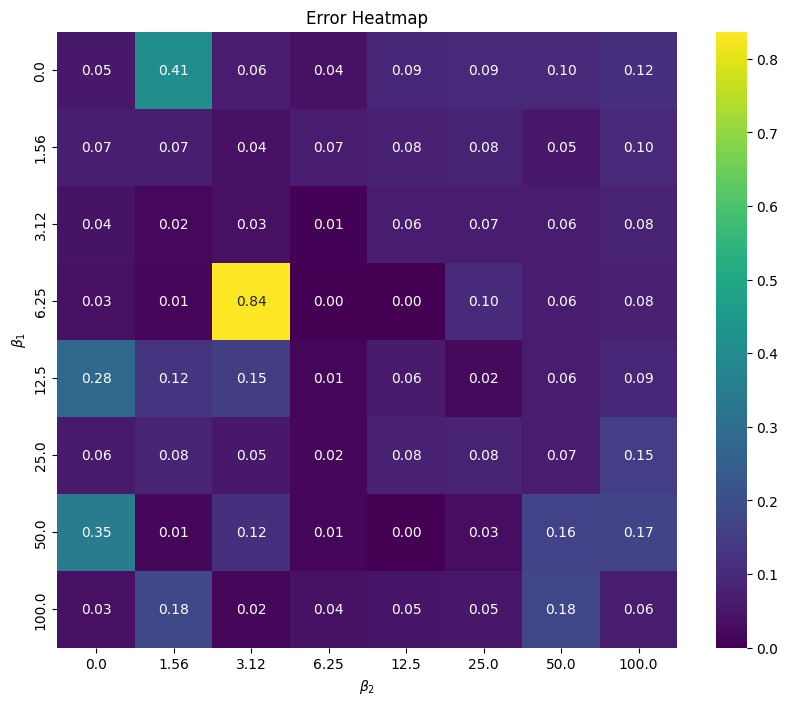

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis")
plt.title('Error Heatmap')
plt.xlabel(r'$\beta_2$')
plt.ylabel(r'$\beta_1$')
plt.savefig("20231102_fig2.pdf", dpi=300)
plt.show()

# 2. Dipole Model

In [3]:
import jax.numpy as jnp

In [5]:
def compute_dipole_electric_potential(s, p, r, kappa=0.2):
    """Compute the electric potential due to a point charge.
        s: 3-d location of the dipole
        p: 3-d moment of the dipole
        r: 3-d location of the electrode
        kappa: electrical conductivity of the torso
    """
    d = r - s # 3-d displacement vector
    e_p = 1/(4*jnp.pi*kappa) * (d @ p)/jnp.linalg.norm(d)**3

    return e_p

def compute_